In [92]:
import  numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


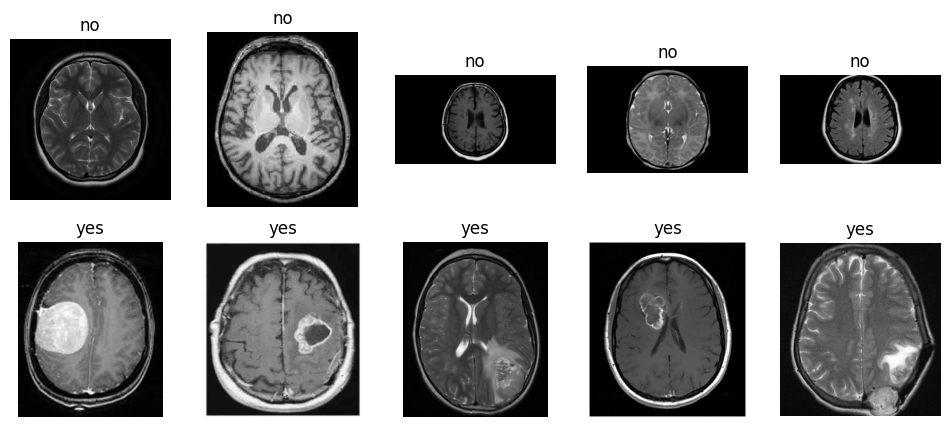

In [2]:
data_dir = "brain_tumor_dataset"

categories = ["no", "yes"]


fig, axes = plt.subplots(2, 5, figsize=(12, 5))


for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    images = os.listdir(path)[:5]

    for j, image_name in enumerate(images):
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(category)
        axes[i, j].axis('off')


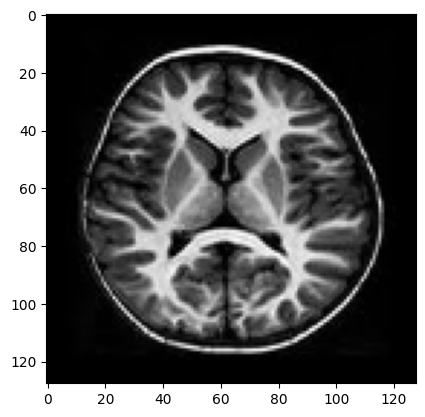

In [75]:
image_size = 128

x = []
y = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)
    
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        
        x.append(img)
        y.append(label)


plt.imshow(x[5], cmap='gray')

In [76]:
x = np.array(x).reshape(-1, image_size, image_size, 1)
x = x.astype('float32') / 255.0
y = np.array(y)

print(x.shape)
print(y.shape)

(253, 128, 128, 1)
(253,)


Text(0, 0.5, 'number')

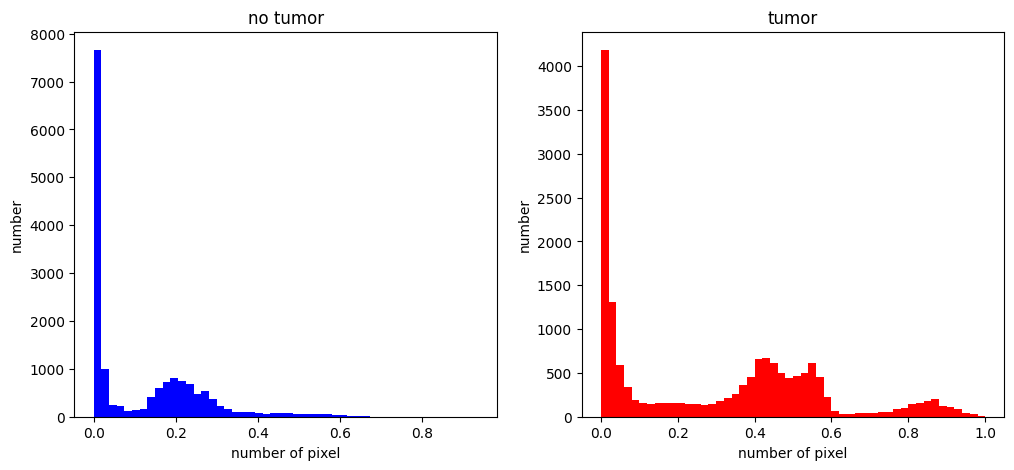

In [77]:
sample_no_tumor = x[np.where(y == 0)[0][0]].ravel()
sample_tumor = x[np.where(y == 1)[0][0]].ravel()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(sample_no_tumor, bins=50, color='blue')
plt.title("no tumor")
plt.xlabel("number of pixel")
plt.ylabel("number")

plt.subplot(1, 2, 2)
plt.hist(sample_tumor, bins=50, color='red')
plt.title("tumor")
plt.xlabel("number of pixel")
plt.ylabel("number")

In [78]:
def extract_hog_features(img):
    features, _ = hog(img, orientations=9,
                      pixels_per_cell=(8, 8), 
                      cells_per_block=(2, 2), visualize=True)
    return features

x_for_hog = x.reshape(x.shape[0], x.shape[1], x.shape[2])

x_hog_features = np.array([extract_hog_features(img) for img in x_for_hog])

print(x_hog_features.shape)

(253, 8100)


In [79]:
x_train, x_test, y_train, y_test = train_test_split(x_hog_features, y, test_size=0.2, random_state=42)

print("num x_train: ", len(x_train))
print("num x_test: ", len(x_test))

num x_train:  202
num x_test:  51


In [15]:
param_grid = {
    'C':[1,10,100],
    'gamma':[1,0.1,0.001,0.0001], 
    'kernel':['linear','rbf']
}
grid_model = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_model.fit(x_train, y_train)

best_param_svc = grid_model.best_params_
print(best_param_svc)

{'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [16]:
svm_model = SVC(**best_param_svc)
svm_model.fit(x_train, y_train)

y_pred_svc = svm_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_svc)
print(f"accuracy svm model: {accuracy:.2f}")

accuracy svm model: 0.94


Text(0.5, 1.0, 'Confusion matrixc (SVM)')

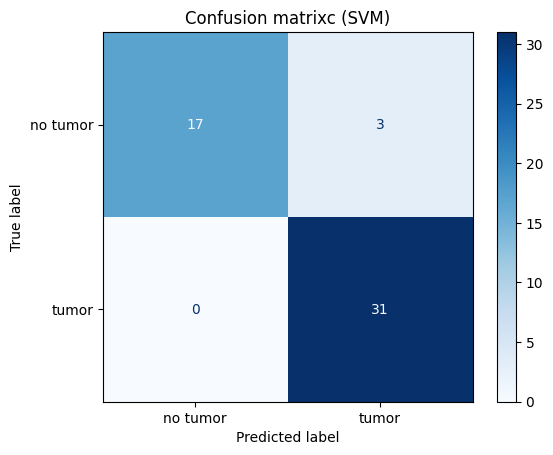

In [21]:
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no tumor", "tumor"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrixc (SVM)')

In [19]:
param_grid_rf = {
    'n_estimators':[10, 50, 100],
    'max_depth':[5, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 8],
}

grid_model = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='accuracy', cv=5, n_jobs=-1)
grid_model.fit(x_train, y_train)

best_param_rf = grid_model.best_params_
print(best_param_rf)

{'max_depth': 10, 'min_samples_split': 8, 'n_estimators': 50}


In [20]:
rf_model = RandomForestClassifier(**best_param_rf)

rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"accuracy rf model: {accuracy:.2f}")

accuracy rf model: 0.96


Text(0.5, 1.0, 'Confusion matrixc (Random Forest)')

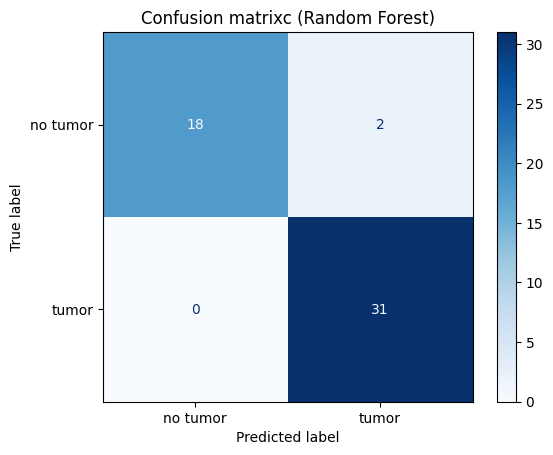

In [26]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no tumor", "tumor"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrixc (Random Forest)')

In [31]:
param_grid_xgb = {
    'n_estimators':[10, 50, 70],
    'max_depth':[5, 10, 15],
    'learning_rate':[0.01, 0.1, 0.2],
}

grid_model = GridSearchCV(XGBClassifier(), param_grid_xgb, scoring='accuracy', cv=5, n_jobs=-1)
grid_model.fit(x_train, y_train)

best_param_xgb = grid_model.best_params_
print(best_param_xgb)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 70}


In [32]:
xgb_model = XGBClassifier(**best_param_xgb)
xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"accuracy xgb model: {accuracy:.2f}")

accuracy xgb model: 0.94


Text(0.5, 1.0, 'Confusion matrixc (XGBoost)')

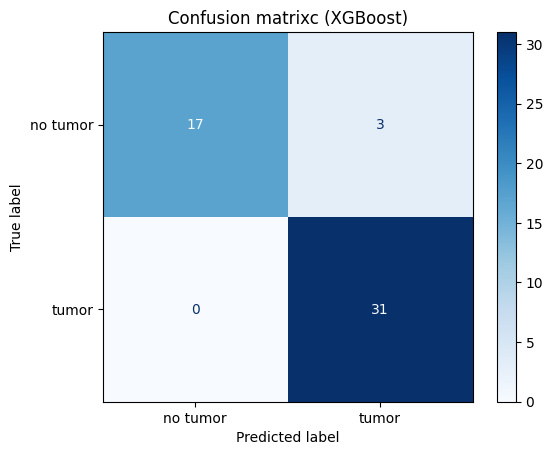

In [33]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no tumor", "tumor"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrixc (XGBoost)')

In [108]:
wrong_indices = np.where((y_test != y_pred_svc) & (y_test != y_pred_rf) & (y_test != y_pred_xgb))[0]

print("wrong indices: ", wrong_indices)

wrong indices:  [17]


In [109]:
x_test_filtered = np.delete(x_test, wrong_indices, axis=0)
x_train_filtered = np.delete(x_train, wrong_indices, axis=0)

y_train_filtered = np.delete(y_train, wrong_indices, axis=0)
y_test_filtered = np.delete(y_test, wrong_indices, axis=0)

In [110]:
# Stacking model with filtered data

base_models = [
    ('svm', svm_model),
    ('xgb', xgb_model),
    ('rf', rf_model),
]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(x_train_filtered, y_train_filtered)

y_pred_stacking = stacking_model.predict(x_test_filtered)
accuracy = accuracy_score(y_test_filtered, y_pred_stacking)
print(f"accuracy stacking: {accuracy:.2f}")

accuracy stacking: 0.96


Text(0.5, 1.0, 'Confusion matrixc (Stacking)')

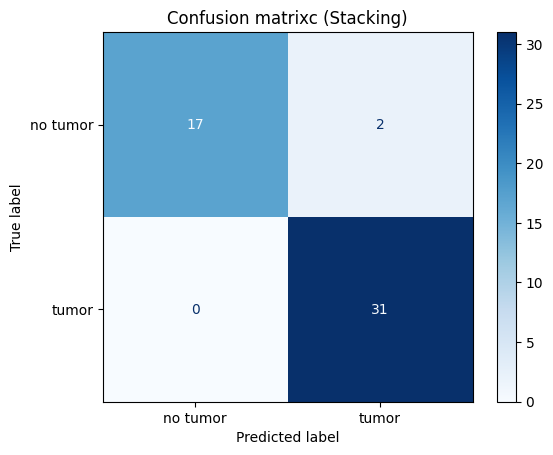

In [111]:
cm = confusion_matrix(y_test_filtered, y_pred_stacking)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no tumor", "tumor"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrixc (Stacking)')